In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
# Bonus vector manipulation
import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime

# **Sentinel-2 WOFS Product Creation**

### Config

Import required DC utils

In [2]:
import datacube
# DC utilities
#from utils_dcal.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils_dcal.data_cube_utilities.dc_water_classifier import wofs_classify
from utils_dcal.data_cube_utilities.import_export import export_xarray_to_netcdf

#SAC utilities
from utils_sac.clean_mask_delete import landsat_qa_clean_mask
from utils_sac.interactive_maps import display_map

Define aoi via wkt polygon (could be subbed or shapefile)

In [3]:
#aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"
#aoi_wkt = "POLYGON((178.24905395508 -18.036804199219, 178.51547241212 -18.038177490235, 178.51547241212 -18.220825195313, 178.25454711915 -18.220825195313, 178.24905395508 -18.036804199219))"
#toms test area
#aoi_wkt = "POLYGON((177.75226467901712 -17.879622210337537,177.80204647833352 -17.879622210337537,177.80204647833352 -17.914988456071715,177.75226467901712 -17.914988456071715,177.75226467901712 -17.879622210337537))"
#larger test area
aoi_wkt = "POLYGON((177.7318858525431 -17.838718461231753,177.8479289433634 -17.838718461231753,177.8479289433634 -17.94980139784152,177.7318858525431 -17.94980139784152,177.7318858525431 -17.838718461231753))"
#smaller river
#aoi_wkt = "POLYGON((177.78570938743283 -17.920888656827586,177.8013734880798 -17.920888656827586,177.8013734880798 -17.936282100441087,177.78570938743283 -17.936282100441087,177.78570938743283 -17.920888656827586))"
#aoi_wkt = "POLYGON((178.11035156251 -17.841796875, 178.83544921876 -17.830810546875, 178.83544921876 -18.297729492187, 178.10485839844 -18.30322265625, 178.11035156251 -17.841796875))"
aoi = gpd.GeoDataFrame(pd.DataFrame({'geoms':[wkt.loads(aoi_wkt)]}), geometry='geoms')


In [4]:
dc = datacube.Datacube(app="na")

In [5]:
area_json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ]
          ]
        ]
      }
    }
  ]
}

In [6]:
lons, lats = zip(*area_json["features"][0]["geometry"]["coordinates"][0])
lat_extents = (min(lats), max(lats))
lon_extents = (min(lons), max(lons))
print("Lat:", lat_extents, "\n"
      "Lon:", lon_extents)

Lat: (-17.94980139784152, -17.838718461231753) 
Lon: (177.7318858525431, 177.8479289433634)


In [7]:
display_map(latitude = lat_extents, longitude = lon_extents)

### Load Data

Generic query specs

In [26]:
from datetime import datetime

query = dict(   latitude = lat_extents,
                longitude = lon_extents,
                output_crs = "EPSG:32760",
                time = (datetime(2018,12,1), datetime(2019,3,1)),
                resolution = (10,10))

Dataset-specifics

In [27]:
scenes = dc.load(product="s2_esa_sr_granule",
               #group_by='solar_day',
               measurements = ["green","red","blue","nir","swir1","swir2","coastal_aerosol","scene_classification"],
               **query)

In [28]:
#scenes['swir1']=scenes.swir_1
#scenes['swir2']=scenes.swir_2
#scenes = scenes.drop('swir_1')
#scenes = scenes.drop('swir_2')

In [29]:
scenes

<xarray.Dataset>
Dimensions:               (time: 33, x: 1235, y: 1235)
Coordinates:
  * time                  (time) datetime64[ns] 2018-12-03T22:30:09 ... 2019-02-28T22:19:39
  * y                     (y) float64 8.015e+06 8.015e+06 ... 8.028e+06
  * x                     (x) float64 5.775e+05 5.775e+05 ... 5.898e+05
Data variables:
    green                 (time, y, x) uint16 7276 7260 7248 7248 ... 0 0 0 0
    red                   (time, y, x) uint16 6772 6796 6812 6784 ... 0 0 0 0
    blue                  (time, y, x) uint16 7700 7700 7700 7636 ... 0 0 0 0
    nir                   (time, y, x) uint16 7484 7500 7492 7516 ... 0 0 0 0
    swir1                 (time, y, x) uint16 3716 3716 3695 3695 ... 0 0 0 0
    swir2                 (time, y, x) uint16 2263 2263 2224 2224 ... 0 0 0 0
    coastal_aerosol       (time, y, x) uint16 7960 7960 7960 7960 ... 0 0 0 0
    scene_classification  (time, y, x) uint8 9 9 9 9 9 9 9 9 ... 0 0 0 0 0 0 0 0
Attributes:
    crs:      EPSG:32760

Check loaded

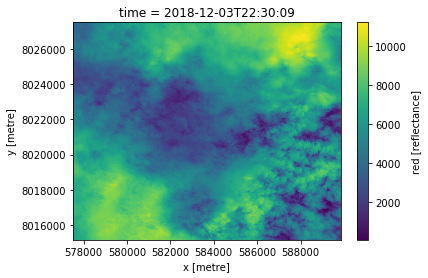

In [30]:
scenes.isel(time = 0).red.plot();

In [31]:
#baseline_composite = scenes.isel(time = 4).red.plot();
#from utils_dcal.data_cube_utilities.dc_rgb import rgb
#rgb(baseline_composite, x_coord='x', y_coord='y')

Create + apply 'cleansky' mask

In [32]:
print(len(scenes))
###from utils_sac.clean_mask_delete import landsat_qa_clean_mask
#clearsky_masks = landsat_qa_clean_mask(scenes, 'SENTINEL_2')
#%%time
clearsky_masks = (
    (scenes.scene_classification == 2) | # DARK_AREA_PIXELS
    (scenes.scene_classification == 4) | # VEGETATION
    (scenes.scene_classification == 5) | # NON_VEGETATION
    (scenes.scene_classification == 6) | # WATER
    (scenes.scene_classification == 7)   # UNCLASSIFIED
)
#clearsky_scenes = scenes.where(clearsky_masks)
#clearsky_scenes.isel(time = 0).red.plot();

8


In [33]:
clearsky_scenes = scenes.where(clearsky_masks)

Apply wofs classification

In [34]:
#water_classes = wofs_classify(scenes, clean_mask=clearsky_masks.values, no_data = np.nan, x_coord='x', y_coord = "y")
water_classes = wofs_classify(clearsky_scenes, no_data = np.nan, x_coord='x', y_coord = "y")

<Figure size 1200x960 with 0 Axes>

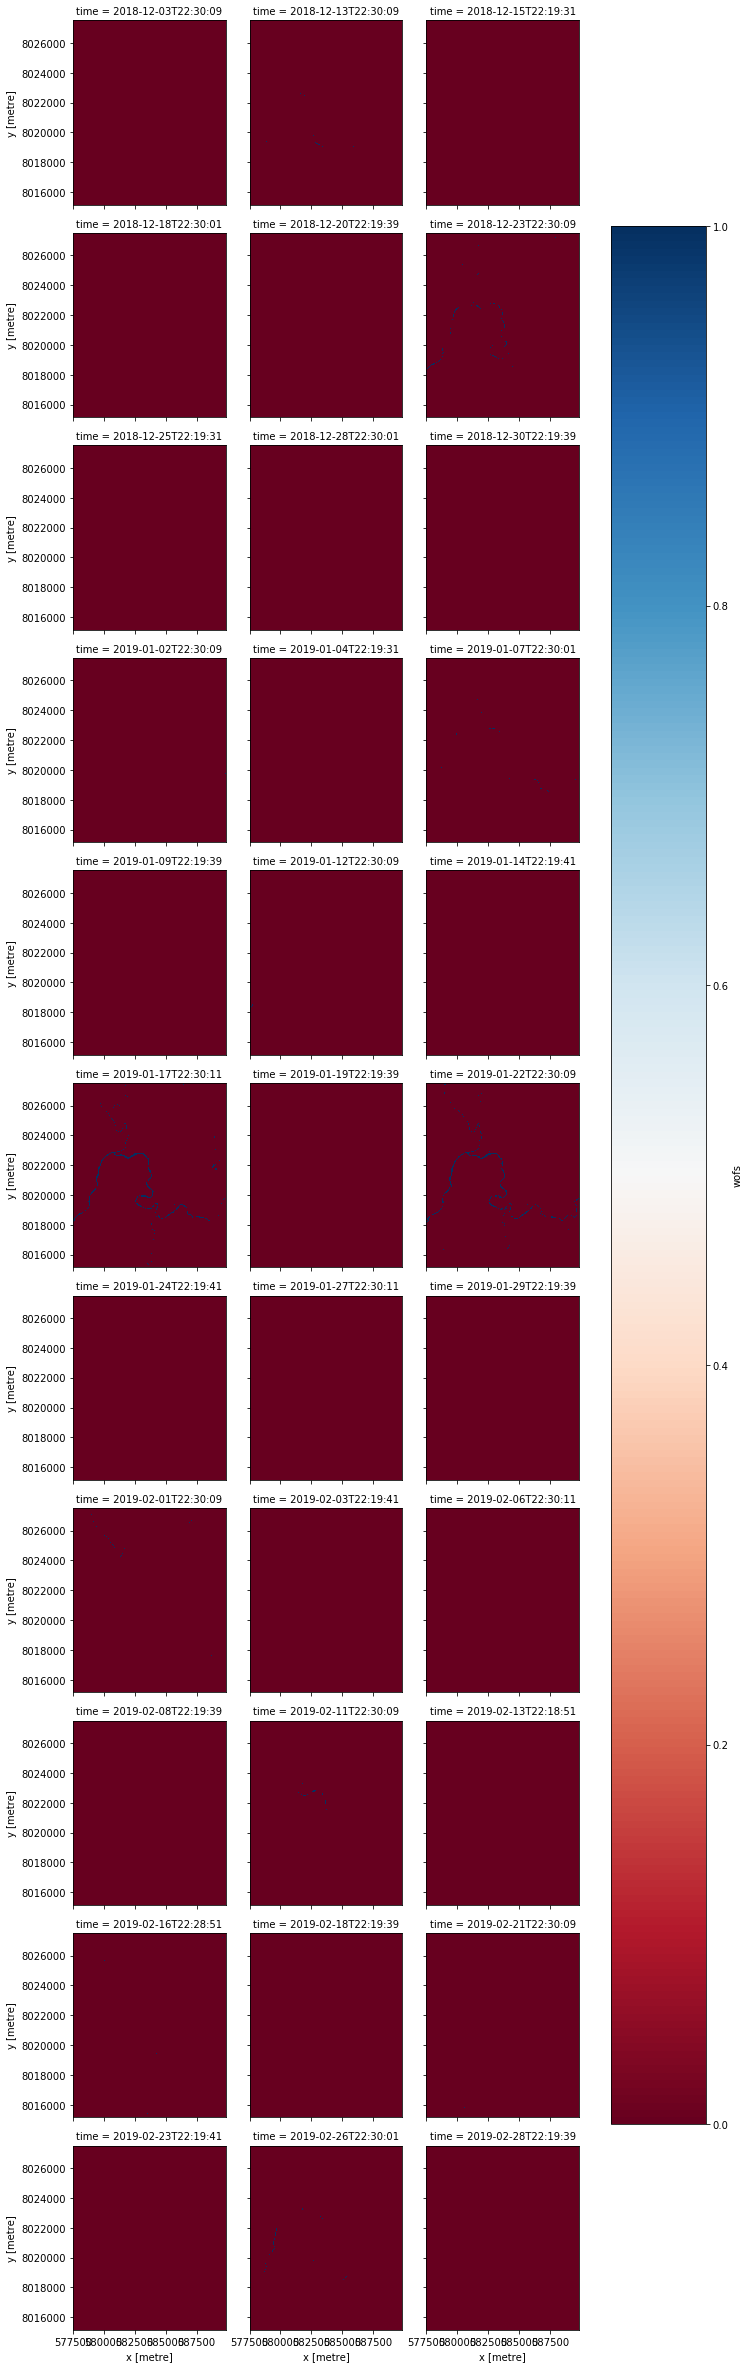

In [35]:
plt.figure(figsize = (10,8), dpi=120)
#water_classes.isel(time = 0).wofs.plot(cmap='RdBu');
water_classes.wofs.plot(col='time', cmap='RdBu', col_wrap=3, vmin=0, vmax=1)

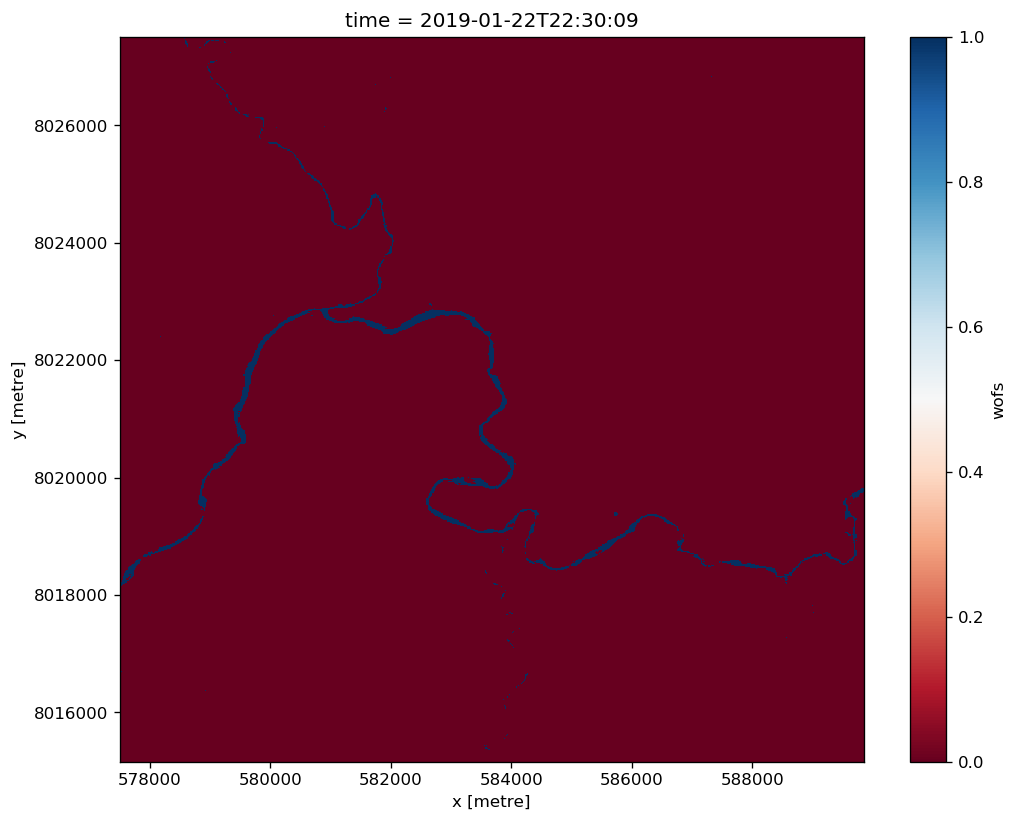

In [36]:
plt.figure(figsize = (10,8), dpi=120)
water_classes.isel(time = 17).wofs.plot(cmap='RdBu', vmin=0, vmax=1);

Visualise wofs summary product

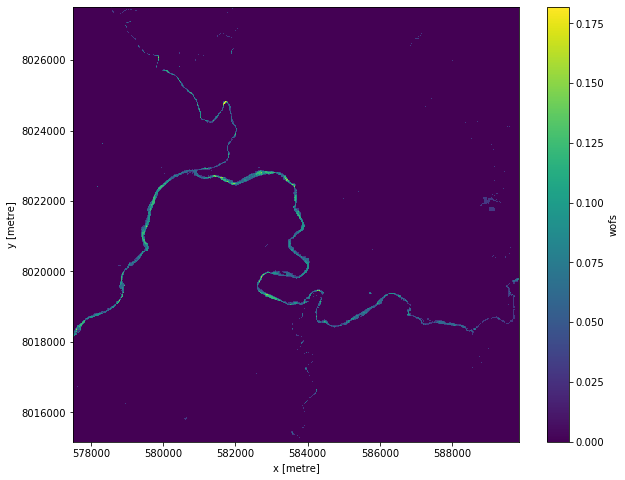

In [37]:
plt.figure(figsize = (10,8))
water_classes.wofs.mean(dim = 'time').plot()

### Export to File with Shared Storage

Define output path

In [20]:
# Ensure the output directory exists before writing to it.
!mkdir -p /home/shared/geo_demos/wofs_testers
output_file_name  =  "/home/shared/geo_demos/wofs_testers/s2_wofs_product_VL.nc"

In [21]:
scenes.attrs

OrderedDict([('crs', CRS('EPSG:32760')), ('dc_partial_load', True)])

In [22]:
dataset_to_output =  water_classes.assign_attrs(scenes.attrs)

In [23]:
dataset_to_output.attrs

OrderedDict([('crs', CRS('EPSG:32760')), ('dc_partial_load', True)])

In [20]:
export_xarray_to_netcdf(dataset_to_output, output_file_name)